In [518]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
import time
import scipy.io as sc

import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import math
from tqdm import tqdm

In [519]:
# define parameters that can be changed in the model
STEP_SIZE = 1

BATCH_SIZE = 7*24
HISTORY = 24
LEARNING_RATE = 0.0001
ATTENTIONHEAD_NUMBER = 4
ATTENTIONHEAD_DIM = 32

In [520]:
# download the data
f = sc.loadmat('data_new.mat')
vals = f['data_new'][0,0]
keys = f['data_new'][0,0].dtype.descr
f['data_new'][0,0]["Y"].shape

# get the values from the struct
data = {}
for i in range(len(keys)-1):
    key = keys[i][0]
    data[str(key)] = vals[key]

datafrm = {"Temperature": data["X"][0,:].reshape(-1), "Turbidity": data["X"][1,:].reshape(-1), "Chlorophyll": data["X"][2,:].reshape(-1), "TargetChlorophyll": data["Y"].reshape(-1)}
data = pd.DataFrame(data=datafrm)

In [521]:
# split the data into train and test partitions, use 94% first samples as test data and rest as train data
Tp = 15977 # test samples
Tv = 850 # number of validation samples
values = data.values.astype(np.float32)
train,test = values[0:Tp,:], values[Tp:,:]

# normalize the data, use train set normalization for test set
scaler = preprocessing.StandardScaler()
train_scaler = scaler.fit(train)
data_norm = train_scaler.transform(values).reshape(-1,4)

index = data.index.values

Window thing

In [522]:
# creating sliding window troughout the data
def sequencing(dataset, start_index=0, end_index=None, history_size=HISTORY, step=STEP_SIZE):
    data = []
    index = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        index.append(i - history_size)

    return np.array(data), np.array(index)

Partition to train and validation. Data is normalized beforehand

In [523]:
def partition(data, pTrain=0.94, pVal = 0.85, save_path=None):
    sequencedData, seqInd = sequencing(data, start_index=0, end_index=None, history_size=HISTORY, step=STEP_SIZE)

    suffleChoice = False
    dataTrain, dataVal = train_test_split(sequencedData, train_size=pTrain, shuffle=suffleChoice, random_state=123)
    indTrain, indVal = train_test_split(seqInd, train_size=pTrain, shuffle=suffleChoice, random_state=123)
    dataVal, dataTest = train_test_split(dataVal, train_size=pVal, shuffle=suffleChoice, random_state=123)
    indVal, indTest = train_test_split(indVal, train_size=pVal, shuffle=suffleChoice, random_state=123)

    return dataTrain, dataVal, dataTest, indTrain, indVal, indTest

Creating input-output pairs

In [524]:
def split(chunk):
    inputs = torch.tensor(chunk[:, :-1, :], device=device, dtype=torch.float32) 
    targets = torch.tensor(chunk[:, 1:, :], device=device, dtype=torch.float32)
    return inputs, targets

# see if gpu is available, if not, train with cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loaders

In [525]:
# create data loaders for efficient data handling
def createLoaders(dataTrain, dataVal, dataTest, batchSize=BATCH_SIZE, responseVariables=3):
    XTrain, YTrain = split(dataTrain)
    XVal, YVal = split(dataVal)
    XTest, YTest = split(dataTest)
    # define indices where the training parameters are
    xindex = [0,1,2]
    XTrain = XTrain[:,:, xindex]
    XVal = XVal[:,:, xindex]
    XTest = XTest[:,:, xindex]
    # check that size is as wanted
    print(XTrain.shape)
    print(XVal.shape)
    print(XTest.shape)
    # for y data take only the 1 step ahead chlorophyll data
    YTrain = YTrain[:,:,responseVariables]
    YVal = YVal[:,:,responseVariables]
    YTest = YTest[:,:,responseVariables]
    # check that size is as wanted
    print(YTrain.shape)
    print(YVal.shape)
    print(YTest.shape)
    # create data loaders
    trainDS = torch.utils.data.TensorDataset(XTrain, YTrain)
    valDS = torch.utils.data.TensorDataset(XVal, YVal)
    testDS = torch.utils.data.TensorDataset(XTest, YTest)
    trainLoader = torch.utils.data.DataLoader(trainDS, batch_size=batchSize)
    valLoader = torch.utils.data.DataLoader(valDS, batch_size=batchSize)
    testLoader = torch.utils.data.DataLoader(testDS, batch_size=None) # do not want test data as batches

    return trainLoader, valLoader, testLoader

trainData, valData, testData, indTrain, indVal, indTest = partition(data_norm)
trainDataset, valDataset, testDataset = createLoaders(trainData, valData, testData, responseVariables=3)

torch.Size([15954, 23, 3])
torch.Size([866, 23, 3])
torch.Size([153, 23, 3])
torch.Size([15954, 23])
torch.Size([866, 23])
torch.Size([153, 23])


TNN implementation

In [526]:
class MultiHeadAttention(nn.Module):
    # define different layers that the MHA will include
    def __init__(self, D, H):
        super(MultiHeadAttention, self).__init__()
        self.H = H # number of heads
        self.D = D # dimension
        
        self.wq = nn.Linear(D, D*H)
        self.wk = nn.Linear(D, D*H)
        self.wv = nn.Linear(D, D*H)

        self.dense = nn.Linear(D*H, D)

    def concat_heads(self, x):
        '''(B, H, S, D) => (B, S, D*H)'''
        B, H, S, D = x.shape
        x = x.permute((0, 2, 1, 3)).contiguous()  # (B, S, H, D)
        x = x.reshape((B, S, H*D))   # (B, S, D*H)
        return x

    def split_heads(self, x):
        '''(B, S, D*H) => (B, H, S, D)'''
        B, S, D_H = x.shape
        x = x.reshape(B, S, self.H, self.D)    # (B, S, H, D)
        x = x.permute((0, 2, 1, 3))  # (B, H, S, D)
        return x

# define the multihead attention itself with predefined layers
    def forward(self, x, mask):

        q = self.wq(x)  # (B, S, D*H)
        k = self.wk(x)  # (B, S, D*H)
        v = self.wv(x)  # (B, S, D*H)

        q = self.split_heads(q)  # (B, H, S, D)
        k = self.split_heads(k)  # (B, H, S, D)
        v = self.split_heads(v)  # (B, H, S, D)

        attention_scores = torch.matmul(q, k.transpose(-1, -2)) #(B,H,S,S)
        attention_scores = attention_scores / math.sqrt(self.D)

        # add the mask to the scaled tensor.
        if mask is not None:
            attention_scores += (mask * -1e9)
        
        attention_weights = nn.Softmax(dim=-1)(attention_scores)
        scaled_attention = torch.matmul(attention_weights, v)  # (B, H, S, D)
        concat_attention = self.concat_heads(scaled_attention) # (B, S, D*H)
        output = self.dense(concat_attention)  # (B, S, D)

        return output, attention_weights

In [527]:
# check that mha returns what it is supposed to
B, S, H, D = 18,11,ATTENTIONHEAD_NUMBER,ATTENTIONHEAD_DIM
mha = MultiHeadAttention(D, H)
out, att = mha.forward(torch.zeros(B, S, D), mask=None)
out.shape, att.shape

(torch.Size([18, 11, 32]), torch.Size([18, 4, 11, 11]))

In [528]:
# Positional encodings
def get_angles(pos, i, D):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(D))
    return pos * angle_rates


def positional_encoding(D, position=20, dim=3, device=device):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(D)[np.newaxis, :],
                            D)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    if dim == 3:
        pos_encoding = angle_rads[np.newaxis, ...]
    elif dim == 4:
        pos_encoding = angle_rads[np.newaxis,np.newaxis,  ...]
    return torch.tensor(pos_encoding, device=device)

# function that implement the look_ahead mask for masking future time steps. 
def create_look_ahead_mask(size, device=device):
    mask = torch.ones((size, size), device=device)
    mask = torch.triu(mask, diagonal=1)
    return mask  # (size, size)

create_look_ahead_mask(6)

# define transformer layer's different type of layers
class TransformerLayer(nn.Module):
    def __init__(self, D, H, hidden_mlp_dim, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.dropout_rate = dropout_rate
        self.mlp_hidden = nn.Linear(D, hidden_mlp_dim)
        self.mlp_out = nn.Linear(hidden_mlp_dim, D)
        self.layernorm1 = nn.LayerNorm(D, eps=1e-9)
        self.layernorm2 = nn.LayerNorm(D, eps=1e-9)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.mha = MultiHeadAttention(D, H)

    # define the transformer layer architecture with predefined layers
    def forward(self, x, look_ahead_mask):
        
        attn, attn_weights = self.mha(x, look_ahead_mask)  # (B, S, D)
        attn = self.dropout1(attn) # (B,S,D)
        attn = self.layernorm1(attn + x) # (B,S,D)

        mlp_act = torch.relu(self.mlp_hidden(attn))
        mlp_act = self.mlp_out(mlp_act)
        mlp_act = self.dropout2(mlp_act)
        
        output = self.layernorm2(mlp_act + attn)  # (B, S, D)

        return output, attn_weights

In [529]:
# check that transformer layer returns the right size. Define D, H, batch size and dropout rate
dl = TransformerLayer(16, 3, BATCH_SIZE, 0.1)
out, attn = dl(x=torch.zeros(5, 7, 16), look_ahead_mask=None)
out.shape, attn.shape

(torch.Size([5, 7, 16]), torch.Size([5, 3, 7, 7]))

In [530]:
class Transformer(nn.Module):
    '''Transformer Decoder Implementating several Decoder Layers.
    '''
    def __init__(self, num_layers, D, H, hidden_mlp_dim, inp_features, out_features, dropout_rate):
        super(Transformer, self).__init__()
        self.sqrt_D = torch.tensor(math.sqrt(D))
        self.num_layers = num_layers
        self.input_projection = nn.Linear(inp_features, D) # multivariate input
        self.output_projection = nn.Linear(D, out_features) # multivariate output
        self.pos_encoding = positional_encoding(D, position=HISTORY-STEP_SIZE)
        self.dec_layers = nn.ModuleList([TransformerLayer(D, H, hidden_mlp_dim, 
                                        dropout_rate=dropout_rate
                                       ) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, mask):
        B, S, D = x.shape
        #print(x.shape)
        attention_weights = {}
        x = self.input_projection(x)
        x *= self.sqrt_D
        
        x += self.pos_encoding[:, :S, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block = self.dec_layers[i](x=x,
                                          look_ahead_mask=mask)
            attention_weights['decoder_layer{}'.format(i + 1)] = block
        
        x = self.output_projection(x)
        
        return x, attention_weights, self # (B,S,S)

In [531]:
# Test Forward pass on the Transformer: 
transformer = Transformer(num_layers=1, D=32, H=1, hidden_mlp_dim=32,
                                       inp_features=3, out_features=1, dropout_rate=0.1)
transformer.to(device)
(inputs, targets) = next(iter(trainDataset))
                         
S = inputs.shape[1]
mask = create_look_ahead_mask(S)
print(mask.shape)
print(inputs.shape)
out, attn,self = transformer.forward(x=inputs, mask=mask)
out.shape, attn["decoder_layer1"].shape

torch.Size([23, 23])
torch.Size([168, 23, 3])


(torch.Size([168, 23, 1]), torch.Size([168, 1, 23, 23]))

In [532]:
# check for weight and biases, not needed for network to run
'''param_sizes = [p.numel() for p in transformer.parameters()]
print(f"number of weight/biases matrices: {len(param_sizes)} "
      f"for a total of {np.sum(param_sizes)} parameters ")'''

'param_sizes = [p.numel() for p in transformer.parameters()]\nprint(f"number of weight/biases matrices: {len(param_sizes)} "\n      f"for a total of {np.sum(param_sizes)} parameters ")'

In [533]:
# define the network that will be used
transformer = Transformer(num_layers=1, D=ATTENTIONHEAD_DIM, H=ATTENTIONHEAD_NUMBER, hidden_mlp_dim=32,
                          inp_features=3, out_features=1, dropout_rate=0.1).to(device)
optimizer = torch.optim.RMSprop(transformer.parameters(), 
                                lr=LEARNING_RATE)

In [534]:
# train the model, define number of epochs and loss lists and minimum validation 
# loss as inf so that we are only saving the model if the validation loss is smaller than the min_val_loss
n_epochs = 50
niter = len(trainDataset)
losses, val_losses = [], []
min_val_loss = np.inf

# measure time taken for training the network
start = time.time()
for e in tqdm(range(n_epochs)):
    
    # one epoch on train set
    transformer.train()
    sum_train_loss = 0.0
    for x,y in trainDataset:
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        # predict a value from neural net
        out, _, _ = transformer(x, mask)
        out = torch.squeeze(out)
        # compute the MSE loss for the prediction
        loss = torch.nn.MSELoss()(out, y)
        sum_train_loss += loss.item()
        # backpropagation to modify weight and biases
        loss.backward()
        # optimizer will handle the change of parameters
        optimizer.step()
    losses.append(sum_train_loss / niter)
    
    # Evaluate on val set
    transformer.eval()
    sum_val_loss = 0.0
    for i, (x, y) in enumerate(valDataset):
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _, _ = transformer(x, mask)
        out = torch.squeeze(out)
        loss = torch.nn.MSELoss()(out, y)
        sum_val_loss += loss.item()
        # if the validation loss is smaller than the minimum loss on earlier validation set, save
        if (loss < min_val_loss):
            min_val_loss = loss
            torch.save(transformer.state_dict(), 'TNN_model.pth') 
    val_losses.append(sum_val_loss / (i + 1))

end = time.time()
print("Training time " + str(end-start))

100%|██████████| 50/50 [01:33<00:00,  1.87s/it]

Training time 93.29737210273743


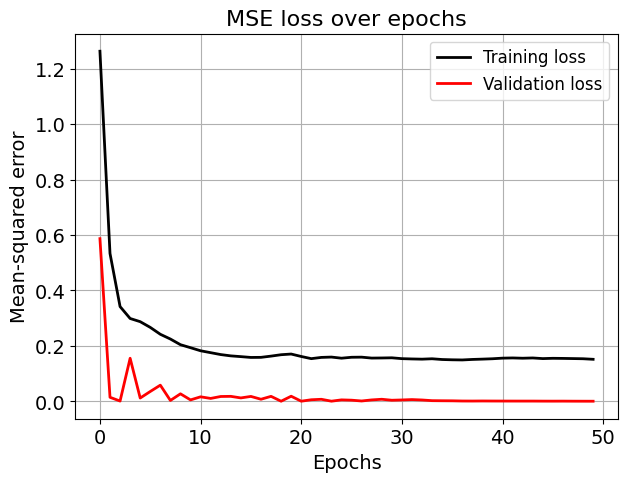

In [535]:
# visualize the losses over the epochs
plt.figure(figsize=(7,5))
plt.title("MSE loss over epochs",fontsize=16)
plt.plot(losses,c='k',lw=2, label="Training loss")
plt.plot(val_losses,c='r',lw=2, label="Validation loss")
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.legend(fontsize=12)
plt.ylabel("Mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [536]:
# load the saved model from the file (model with smallest validation loss)
transformer.load_state_dict(torch.load("TNN_model.pth"))
# set the net to evaluation mode so no training is done
transformer.eval()

test_losses = []
start = time.time()
# no gradients are computed in the testing phase for saving resources
with torch.no_grad():
    # Evaluate on test set
    test_loss = 0.0
    test_out = []
    # since there is no batches in the test dataset, we will get all the testing samples at once
    for i, (x, y) in enumerate(testDataset):
        # if first test sample, now we have all the right values for the chlorophyll so set last_x as as the sample
        if (i == 0):
            last_x = x.reshape(1, HISTORY - STEP_SIZE, 3)
        # when some other than first sample, set last predicted value as the chlorophyll value on the last history sample
        else:
            # add the predicted chlorophyll value to the chlorophyll value with actual temperature and turbidity values
            last_x = np.roll(last_x.numpy(), -1, axis=1)
            #print(last_x)
            last_x[:,-1,0] = x[-1,0]
            last_x[:,-1,1] = x[-1,1]
            last_x[:,-1,2] = out.numpy()
            last_x = torch.tensor(last_x)
        S = last_x.shape[1]
        mask = create_look_ahead_mask(S)
        # make a new prediction
        out, _, _ = transformer(last_x, mask)
        out = torch.squeeze(out)[0]
        y = torch.squeeze(y)
        #print(y[0])
        test_out.append(out.numpy())
        loss = torch.nn.MSELoss()(out, y[0])
        test_loss += loss.item()
            
    test_losses.append(test_loss / (1+i))
    
end = time.time()
print("Testing time " + str(end-start))
test_out = np.vstack(test_out)

Testing time 0.10926413536071777


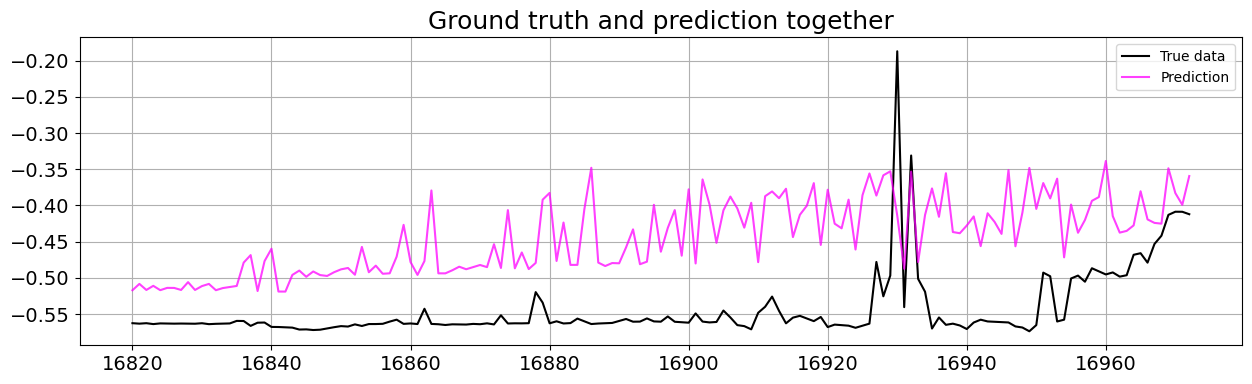

Mean squared error: [0.01303527688834317]


In [537]:
# visualize the prediction against the ground truth
plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together",fontsize=18)

plt.plot(indTest, data_norm[indTest,3],c='black', label="True data")
#plt.plot(indTest, data_norm[indTest,0],c='blue', label="Temperature")
#plt.plot(indTest, 0.01*data_norm[indTest,1],c='green', label="Turbidity")
plt.plot(indTest, test_out, c='magenta',  markersize=2,alpha=0.75, label="Prediction")

plt.legend(fontsize=10)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# display the mse value
print("Mean squared error: " + str(test_losses))

In [538]:
'''import torchvision
from torchview import draw_graph


i, (x, y) = next(iter(enumerate(valDataset)))
model = Transformer(num_layers=1, D=32, H=1, hidden_mlp_dim=32,
                                       inp_features=6, out_features=1, dropout_rate=0.1)
#print(transformer(x, create_look_ahead_mask(6)))
k,h, model = transformer(x, create_look_ahead_mask(6))
model_graph = draw_graph(model,input_data=[x,create_look_ahead_mask(6)], device=device)
model_graph.visual_graph'''

'import torchvision\nfrom torchview import draw_graph\n\n\ni, (x, y) = next(iter(enumerate(valDataset)))\nmodel = Transformer(num_layers=1, D=32, H=1, hidden_mlp_dim=32,\n                                       inp_features=6, out_features=1, dropout_rate=0.1)\n#print(transformer(x, create_look_ahead_mask(6)))\nk,h, model = transformer(x, create_look_ahead_mask(6))\nmodel_graph = draw_graph(model,input_data=[x,create_look_ahead_mask(6)], device=device)\nmodel_graph.visual_graph'